# Machine Learning - Clustering and Dimensionality Reduction
## Assignment 4
### Rhichard Koh

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
class Autoencoder(nn.Module):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
    nn.Linear(28 * 28, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, encoding_dim),
    )
    self.decoder = nn.Sequential(
    nn.Linear(encoding_dim, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 28 * 28),
    nn.Sigmoid(), # Sigmoid activation to ensure outputs are in [0,1]
    )

  def forward(self, x):
    x = x.view(x.size(0), -1) # Flatten the input
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [3]:
from torchsummary import summary
# Load the trained model
complex_autoencoder = Autoencoder(encoding_dim=2)
# Move the model to the CPU
# complex_autoencoder.to('cuda:0')
# Print the summary of the encoder
summary(complex_autoencoder.encoder, (128, 1, 784)) # Assuming MNIST images (1 channel, 28x28)
# Print the summary of the decoder
summary(complex_autoencoder.decoder, (2,)) # Assuming encoding_dim is 2


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1          [-1, 128, 1, 512]         401,920
              ReLU-2          [-1, 128, 1, 512]               0
            Linear-3          [-1, 128, 1, 256]         131,328
              ReLU-4          [-1, 128, 1, 256]               0
            Linear-5            [-1, 128, 1, 2]             514
Total params: 533,762
Trainable params: 533,762
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.50
Params size (MB): 2.04
Estimated Total Size (MB): 3.92
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]             768
              ReLU-2                  [-1

In [4]:
# Function to train the autoencoder
def train_autoencoder(model, dataloader, criterion, optimizer,
  num_epochs=10):
  for epoch in range(num_epochs):
    for data in dataloader:
      inputs, _ = data
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, inputs.view(inputs.size(0), -1))
      loss.backward()
      optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


In [5]:
# Set random seed for reproducibility
torch.manual_seed(42)
# Define hyperparameters
encoding_dim = 2
batch_size = 128
learning_rate = 0.001
num_epochs = 20
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True,
transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
shuffle=True)
# Initialize the autoencoder model, criterion, and optimizer
autoencoder_model = Autoencoder(encoding_dim=encoding_dim)
criterion = nn.MSELoss() # Mean Squared Error Loss
optimizer = optim.Adam(autoencoder_model.parameters(), lr=learning_rate)
# Train the autoencoder
train_autoencoder(autoencoder_model, train_loader, criterion, optimizer,
num_epochs=num_epochs)

100%|██████████| 9912422/9912422 [00:00<00:00, 122243751.91it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 71172558.06it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43868920.17it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11737848.90it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch 1/20, Loss: 0.048227377235889435
Epoch 2/20, Loss: 0.04274308308959007
Epoch 3/20, Loss: 0.03701207786798477
Epoch 4/20, Loss: 0.04118278995156288
Epoch 5/20, Loss: 0.04034752771258354
Epoch 6/20, Loss: 0.040008291602134705
Epoch 7/20, Loss: 0.04075079783797264
Epoch 8/20, Loss: 0.03756662458181381
Epoch 9/20, Loss: 0.037444546818733215
Epoch 10/20, Loss: 0.037554457783699036
Epoch 11/20, Loss: 0.03652656823396683
Epoch 12/20, Loss: 0.03581954538822174
Epoch 13/20, Loss: 0.0340394489467144
Epoch 14/20, Loss: 0.04035919904708862
Epoch 15/20, Loss: 0.035538483411073685
Epoch 16/20, Loss: 0.03619882091879845
Epoch 17/20, Loss: 0.034360650926828384
Epoch 18/20, Loss: 0.03576340153813362
Epoch 19/20, Loss: 0.03701302781701088
Epoch 20/20, Loss: 0.03649537265300751


In [6]:
torch.save(autoencoder_model.state_dict(), 'autoencoder_model.pth')
print("Trained model saved.")


Trained model saved.


[7 2 1 ... 4 5 6]


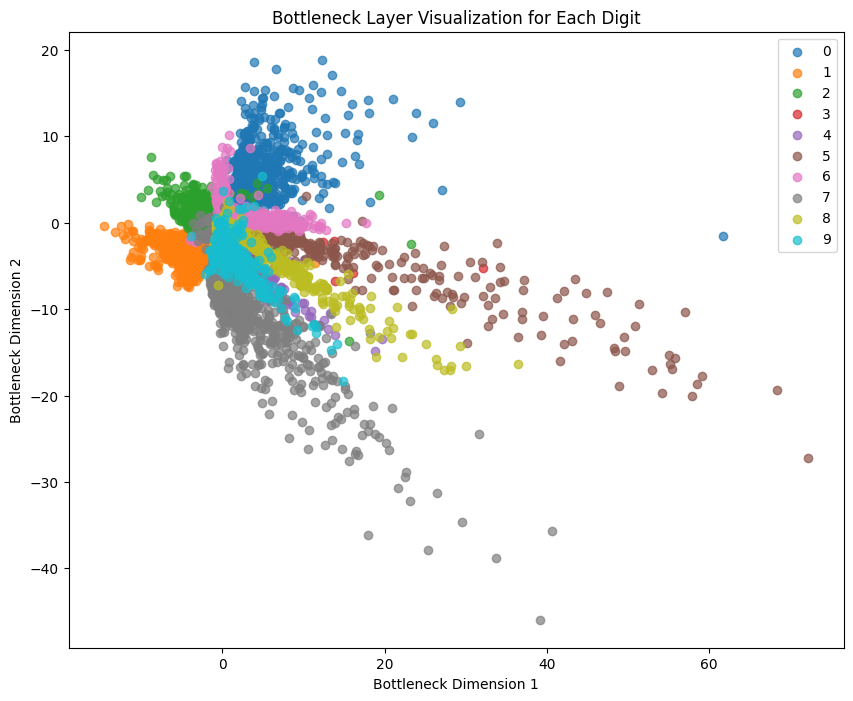

In [7]:
# Function to visualize the bottleneck layer for each digit
def visualize_bottleneck(encoder, dataloader):
  encoder.eval()
  all_embeddings = []
  all_labels = []
  with torch.no_grad():
    for data in dataloader:
      inputs, labels = data
      embeddings = encoder(inputs.view(inputs.size(0), -1)).detach().numpy()
      all_embeddings.append(torch.from_numpy(embeddings)) # Convert to PyTorch tensor
      all_labels.append(labels)
  all_embeddings = torch.cat(all_embeddings, dim=0)
  all_labels = torch.cat(all_labels, dim=0).numpy() # Convert to NumPy array
  # Plot 2D representations, color-coded by digit label
  plt.figure(figsize=(10, 8))
  print(all_labels)
  for digit in range(10):
    digit_indices = (all_labels == digit)
    plt.scatter(all_embeddings[digit_indices, 0], all_embeddings[digit_indices, 1], label=str(digit), alpha=0.7)

  plt.title('Bottleneck Layer Visualization for Each Digit')
  plt.xlabel('Bottleneck Dimension 1')
  plt.ylabel('Bottleneck Dimension 2')
  plt.legend()
  plt.show()

# Load the trained autoencoder
autoencoder_model = Autoencoder(encoding_dim=2) # Assuming you have a trained Autoencoder
autoencoder_model.load_state_dict(torch.load('autoencoder_model.pth')) # Load the saved model
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST(root='./data', train=False, download=True,
transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset),
shuffle=False)
# Visualize the bottleneck layer for each digit
visualize_bottleneck(autoencoder_model.encoder, test_loader)

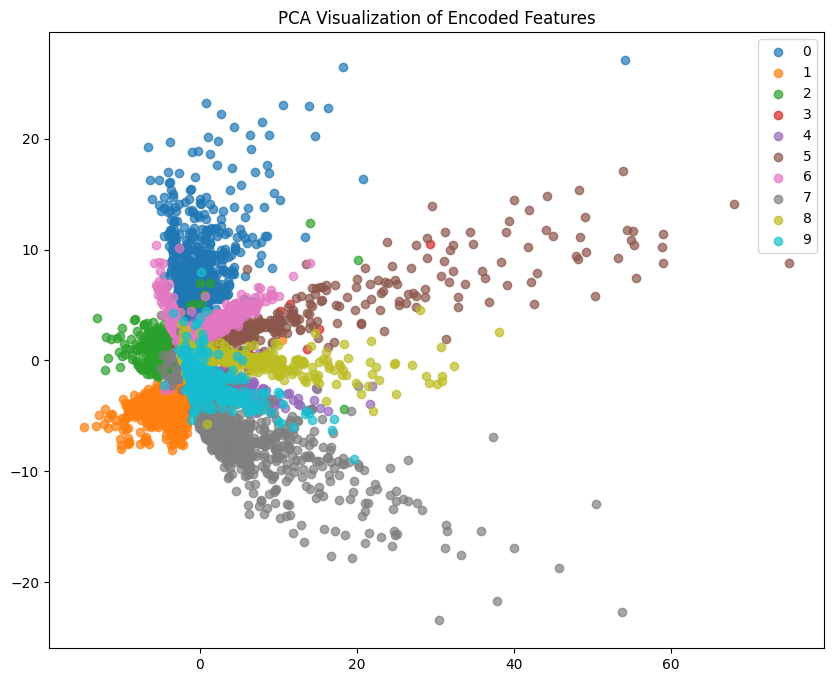

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.007s...
[t-SNE] Computed neighbors for 10000 samples in 0.256s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.102539
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.485607
[t-SNE] KL divergence after 300 iterations: 1.981296


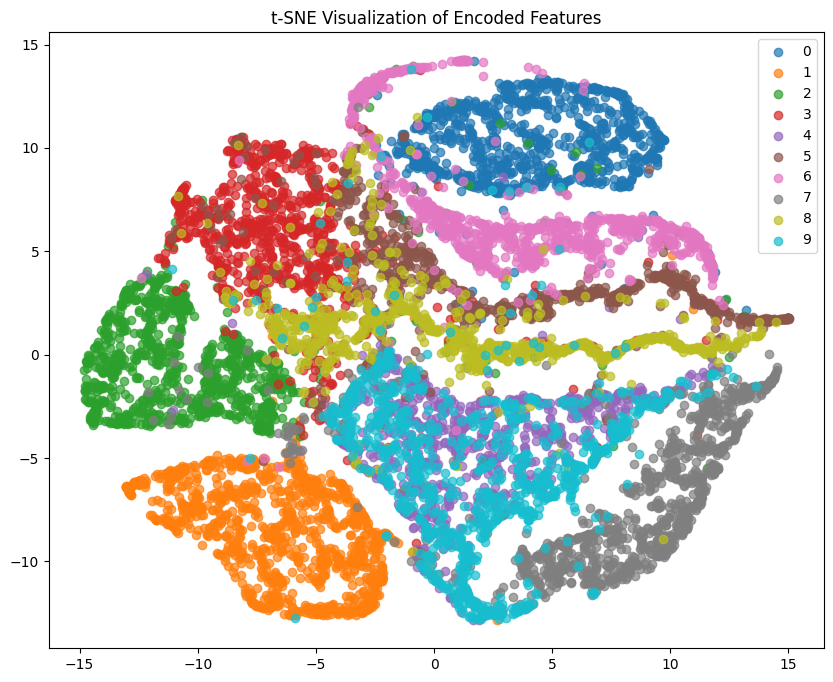

[7 2 1 ... 4 5 6]


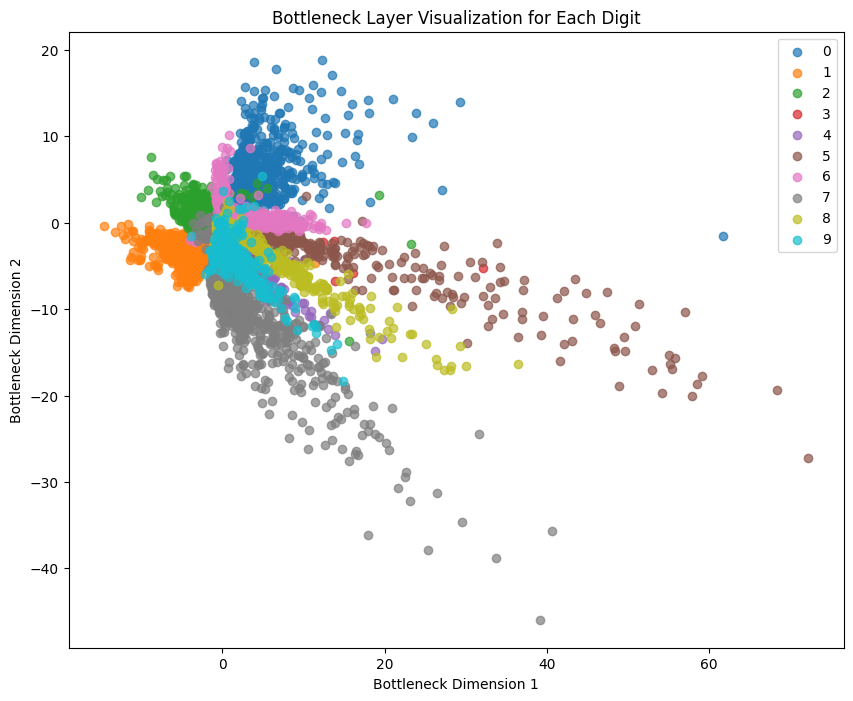

In [8]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def extract_encoded_features(encoder, dataloader):
    encoder.eval()
    all_encoded_features = []
    all_labels = []
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            encoded_features = encoder(inputs.view(inputs.size(0), -1))
            all_encoded_features.append(encoded_features)
            all_labels.append(labels)
    all_encoded_features = torch.cat(all_encoded_features, dim=0).numpy()  # Convert to numpy array
    all_labels = torch.cat(all_labels, dim=0).numpy()  # Convert to numpy array
    return all_encoded_features, all_labels

def visualize_with_pca(features, labels):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)
    plt.figure(figsize=(10, 8))
    for digit in range(10):
        indices = (labels == digit)
        plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=str(digit), alpha=0.7)
    plt.title('PCA Visualization of Encoded Features')
    plt.legend()
    plt.show()

def visualize_with_tsne(features, labels):
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_result = tsne.fit_transform(features)
    plt.figure(figsize=(10, 8))
    for digit in range(10):
        indices = (labels == digit)
        plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], label=str(digit), alpha=0.7)
    plt.title('t-SNE Visualization of Encoded Features')
    plt.legend()
    plt.show()

# Assuming autoencoder_model is your trained Auto-Encoder model
encoded_features, labels = extract_encoded_features(autoencoder_model.encoder, test_loader)

# Visualize using PCA
visualize_with_pca(encoded_features, labels)

# Visualize using t-SNE
visualize_with_tsne(encoded_features, labels)

# Continue with your existing function to visualize the bottleneck layer
visualize_bottleneck(autoencoder_model.encoder, test_loader)


In [11]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)
X, y = mnist.data / 255.0, mnist.target.astype(int)  # Normalize and convert labels to integers

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [12]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [13]:
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

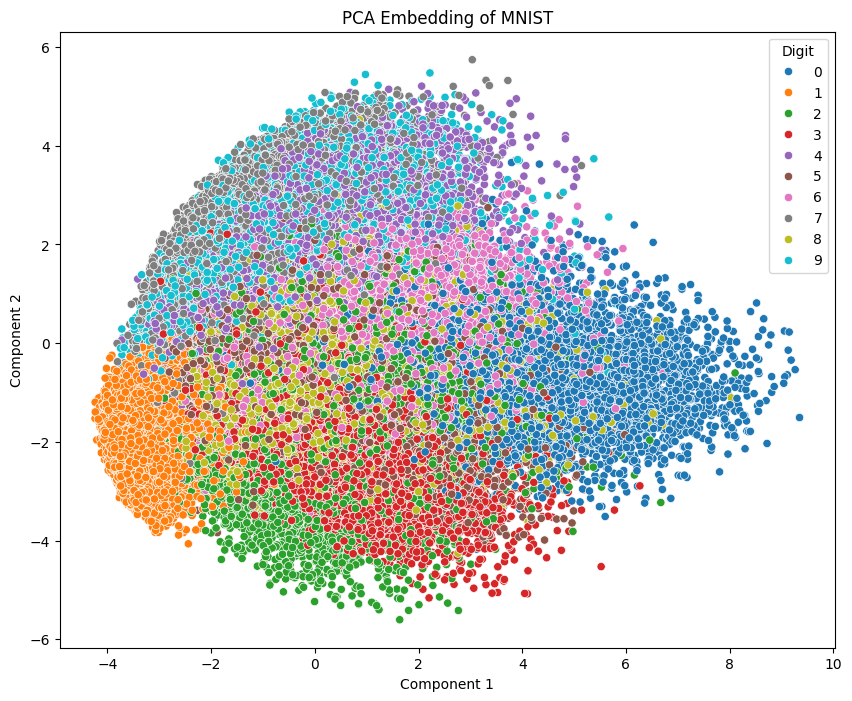

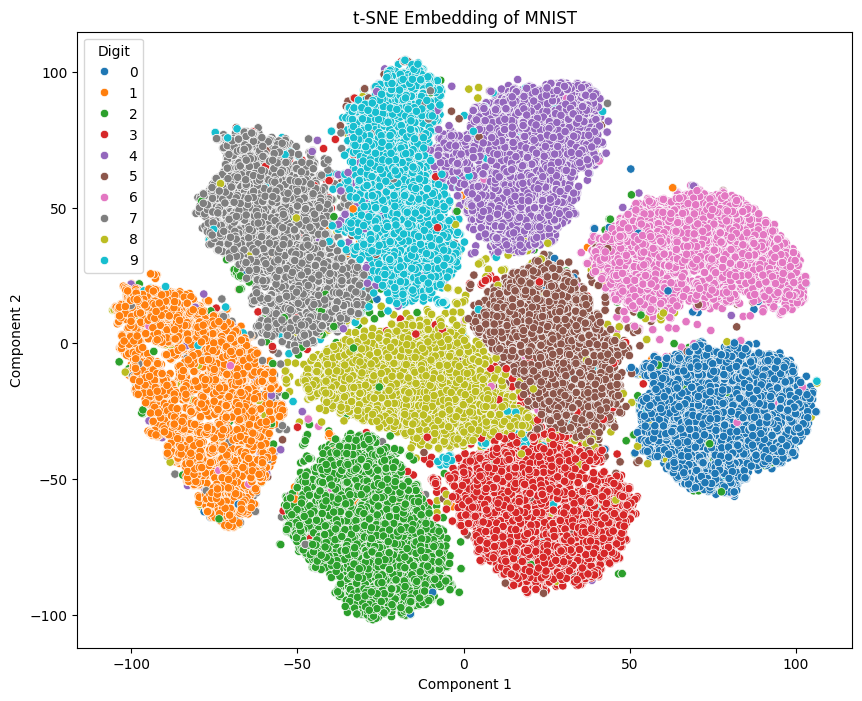

In [17]:
# Function to plot the embeddings after applying PCA and T-sne directly to the MNIST dataset
def plot_embedding_seaborn(X, y, title):
    df = pd.DataFrame(X, columns=['Component 1', 'Component 2'])
    df['Digit'] = y
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df, x='Component 1', y='Component 2', hue='Digit', palette=sns.color_palette("tab10", 10), legend='full')
    plt.title(title)

plot_embedding_seaborn(X_pca, y, "PCA Embedding of MNIST")
plot_embedding_seaborn(X_tsne, y, "t-SNE Embedding of MNIST")
plt.show()

We simplified our process of working with images by using a method that breaks down and then reconstructs the images. To make the data easier to work with, we first condensed the information using a technique called PCA, and then we made the groups within the data more clear using another method called T-SNE. After reconstructing the images, we noticed that they looked better when we used T-SNE because the different groups in the images were easier to tell apart. While PCA also grouped the images into clusters, T-SNE did a better job at this. When we tried using PCA directly on the Mnist dataset (a collection of handwritten digits), it didn't work very well. However, we found that PCA works much better for grouping the images when it's used together with our break down and reconstruct method, as shown in our graph. T-SNE, which is specifically designed for dealing with complex data, also seems to work better with this method because it makes the groups in the images more distinct.